In [1]:
import warnings
warnings.filterwarnings('ignore')

import copy
import datetime
import h5py
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import scienceplots
import torch
import torch.nn as nn
import torchvision
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import sys

from datetime import datetime
from gc import collect
from os import cpu_count
from scipy.io import savemat, loadmat
from sklearn.model_selection import train_test_split
from time import sleep
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from tqdm import tqdm

sys.path.append(f"{os.getcwd()}/ViT architecture/working ViT")
sys.path.append(f"{os.getcwd()}/scripts/")
from VisionTransformer_working import VisionTransformer as Vit_old

sys.path.append(f"{os.getcwd()}/ViT architecture/Architecture tryouts/DPT/")
from VisionTransformer_working_for_DPT import VisionTransformer as Vit
from VisionTransformer_working_for_DPT import VisionTransformer3 as Vit3
sys.path.append(f"/home/alexrichard/PycharmProjects/UQ_DL-TFM/mltfm/")
from train_network import get_unet

2023-08-03 21:27:30.367674: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-03 21:27:30.838872: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-03 21:27:30.838913: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-03 21:27:30.838918: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
random_seed = 2
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
cudnn.benchmark = True

In [3]:
collect()
torch.cuda.empty_cache()
torch.set_printoptions(precision=6)
device = torch.device('cpu')
print(f"Running on device: {device}")

Running on device: cpu


## Load models

In [4]:
vit = Vit(dspl_size=104, 
          patch_size=8, 
          embed_dim=128,
          depth=6,
          n_heads=4,
          mlp_ratio=1.0,
          qkv_bias=False,
          p=0.1,
          attn_p=0.1,
          drop_path=0.).float()

path_to_vit = '/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/ViT architecture/Architecture tryouts/DPT/logs_and_weights/ViT-final_2023-Jul-27 16:26:18/ViT-final_2023-Jul-27 16:26:18.pth'

vit.load_state_dict(torch.load(path_to_vit, map_location=torch.device('cpu'))['best_model_weights'], strict=True)        

<All keys matched successfully>

In [5]:
vit_high = Vit(dspl_size=104, 
          patch_size=8, 
          embed_dim=128,
          depth=6,
          n_heads=4,
          mlp_ratio=1.0,
          qkv_bias=False,
          p=0.1,
          attn_p=0.1,
          drop_path=0.).float()

path_to_vit = '/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/ViT architecture/Architecture tryouts/DPT/logs_and_weights/ViT-final_noise:0.52023-Jul-28 11:16:57/ViT-final_noise:0.52023-Jul-28 11:16:57.pth'

vit_high.load_state_dict(torch.load(path_to_vit, map_location=torch.device('cpu'))['best_model_weights'], strict=True)        

<All keys matched successfully>

In [6]:
prob_vit = Vit3(dspl_size=104, 
                patch_size=8, 
                embed_dim=128,
                depth=4,
                n_heads=4,
                mlp_ratio=1.0,
                qkv_bias=False,
                p=0.1,
                attn_p=0.1,
                drop_path=0.).float()

path_to_prob_vit = '/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/ViT architecture/Architecture tryouts/DPT/logs_and_weights/ViT-GNLL_final2023-May-17 23:02:08/ViT-GNLL_final2023-May-17 23:02:08.pth'

prob_vit.load_state_dict(torch.load(path_to_prob_vit, map_location=torch.device('cpu'))['best_model_weights'], strict=True)        

<All keys matched successfully>

In [7]:
# cnn = keras.models.load_model('/home/alexrichard/PycharmProjects/UQ_DL-TFM/mltfm/CNN_noisy-2023-Mar-21 18:13:25_checkpoint.h5')
cnn = keras.models.load_model('/home/alexrichard/PycharmProjects/UQ_DL-TFM/mltfm/CNN_noisy_final-2023-May-18 23:46:36_checkpoint.h5')

2023-08-03 21:27:38.856641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-03 21:27:38.857723: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-03 21:27:38.857923: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-03 21:27:38.858371: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

## Load data

In [8]:
real_cells = []
real_dspl = torch.zeros((14, 2, 104, 104))
directory = '/home/alexrichard/LRZ Sync+Share/ML in Physics/Repos/DL-TFM-main/cells/cells/dspl'

for i, file in enumerate(os.listdir(directory)):
    filename = os.fsdecode(file)
    if filename.endswith(".mat"):
        real_cell = {}
        file = loadmat(directory+'/'+filename)
        real_cell['brdx'] = np.rot90(file['brdx'], 2)
        real_cell['brdy'] = np.rot90(file['brdy'], 2)
        real_cell['dspl'] = torch.tensor(np.transpose(file['dspl']))
        real_cell['vit_pred'] = vit((1 / 200.2) * real_cell['dspl'].unsqueeze(0).float()) * 10670
        real_cell['vit_high_pred'] = vit_high((1 / 200.2) * real_cell['dspl'].unsqueeze(0).float()) * 10670
        real_cell['prob_vit_pred'] = prob_vit((1 / 200.2) * real_cell['dspl'].unsqueeze(0).float()) * 10670
        real_cell['cnn_pred'] = cnn.predict(np.expand_dims(np.moveaxis(np.array(real_cell['dspl']), 0, 2), 0)) * 10670
        real_cells.append(real_cell)

2023-08-03 21:27:45.377957: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500


1/1 [==============================] - 0s 14ms/step


In [8]:
Bay_FTTC_results = loadmat('/home/alexrichard/LRZ Sync+Share/ML in Physics/Repos/Easy-to-use_TFM_package-master/test_data/real_cells/Samples/Bay-FTTC_results_24-05-23.mat')
TFM_results = Bay_FTTC_results['TFM_results']['traction'][0][0].T.reshape((2, 102, 102), order='F')
TFM_results[:, 0:3, :] = 0
TFM_results[:, :, 0:3] = 0
TFM_results[:, 99:, :] = 0
TFM_results[:, :, 99:] = 0
TFM_results_padded = F.pad(input=torch.tensor(TFM_results).float(), pad=(1, 1, 1, 1), mode='constant', value=0)

In [9]:
real_cells[i]['dspl'].shape

torch.Size([2, 104, 104])

In [ ]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

get_ipython().run_line_magic('matplotlib', 'notebook')
%matplotlib inline
plt.style.use(['science', 'grid', 'muted'])

fig, axs = plt.subplots(2, 3, figsize=(13, 8))
fig.tight_layout(pad=2, w_pad=0, h_pad=4)

norm = matplotlib.colors.Normalize(vmin=0.0, vmax=np.max(np.sqrt(np.array(dspl_padded_big[0, :, :] ** 2 + dspl_padded_big[1, :, :] ** 2))))
C = np.sqrt(dspl_padded_big[0, :, :] ** 2 + dspl_padded_big[1, :, :] ** 2)
im = axs[0,0].pcolormesh(C, shading='gouraud', norm=norm)
colorbar = fig.colorbar(im, ax=axs[0,0], pad=0.02)
colorbar.ax.set_title(u'\xb5m', fontsize=17)
axs[0,0].set(adjustable='box', aspect='equal')
axs[0,0].set_title('Displacement', pad=10, fontsize=25)

norm = matplotlib.colors.Normalize(vmin=0.0, vmax=np.max(np.sqrt(np.array(bfttc_result[0, :, :] ** 2 + bfttc_result[1, :, :] ** 2))))
C = np.sqrt(bfttc_result_large[0, :, :] ** 2 + bfttc_result_large[1, :, :] ** 2)
im = axs[0,1].pcolormesh(C, shading='gouraud', norm=norm)
colorbar = fig.colorbar(im, ax=axs[0,1], pad=0.02, norm=norm)
colorbar.ax.set_title(u'Pa', fontsize=17)
axs[0,1].set(adjustable='box', aspect='equal')
axs[0,1].set_title('BFTTC', pad=10, fontsize=25)

norm = matplotlib.colors.Normalize(vmin=0.0, vmax=np.max(np.sqrt(cnn_pred_large[0, :, :, 0] ** 2 + cnn_pred_large[0, :, :, 1] ** 2)))
C = np.sqrt(cnn_pred_large[0, :, :, 0] ** 2 + cnn_pred_large[0, :, :, 1] ** 2)
im = axs[0,2].pcolormesh(C, shading='gouraud', norm=norm)
colorbar = fig.colorbar(im, ax=axs[0,2], pad=0.02, norm=norm)
colorbar.ax.set_title(u'Pa', fontsize=17)
axs[0,2].set(adjustable='box', aspect='equal')
axs[0,2].set_title('CNN', pad=10, fontsize=25)

norm = matplotlib.colors.Normalize(vmin=0.0, vmax=np.max(np.sqrt(vit_pred_large[0, 0, :, :].detach().numpy() ** 2 + vit_pred_large[0, 1, :, :].detach().numpy() ** 2)))
C = np.sqrt(vit_pred_large[0, 0, :, :].detach().numpy() ** 2 + vit_pred_large[0, 1, :, :].detach().numpy() ** 2)
im = axs[1,0].pcolormesh(C, shading='gouraud', norm=norm)
colorbar = fig.colorbar(im, ax=axs[1,0], pad=0.02, norm=norm)
colorbar.ax.set_title(u'Pa', fontsize=17)
axs[1,0].set(adjustable='box', aspect='equal')
axs[1,0].set_title('ViT', pad=10, fontsize=25)

norm = matplotlib.colors.Normalize(vmin=0.0, vmax=np.max(np.sqrt(vit_pred_high_large[0, 0, :, :].detach().numpy() ** 2 + vit_pred_high_large[0, 1, :, :].detach().numpy() ** 2)))
C = np.sqrt(vit_pred_high_large[0, 0, :, :].detach().numpy() ** 2 + vit_pred_high_large[0, 1, :, :].detach().numpy() ** 2)
im = axs[1,1].pcolormesh(C, shading='gouraud', norm=norm)
colorbar = fig.colorbar(im, ax=axs[1,1], pad=0.02, norm=norm)
colorbar.ax.set_title(u'Pa', fontsize=17)
axs[1,1].set(adjustable='box', aspect='equal')
axs[1,1].set_title('ViT (high noise)', pad=10, fontsize=25)

norm = matplotlib.colors.Normalize(vmin=0.0, vmax=np.max(np.sqrt(prob_vit_pred_large[0, 0, :, :].detach().numpy() ** 2 + prob_vit_pred_large[0, 1, :, :].detach().numpy() ** 2)))
C = np.sqrt(prob_vit_pred_large[0, 0, :, :].detach().numpy() ** 2 + prob_vit_pred_large[0, 1, :, :].detach().numpy() ** 2)
im = axs[1,2].pcolormesh(C, shading='gouraud', norm=norm)
colorbar = fig.colorbar(im, ax=axs[1,2], pad=0.02, norm=norm)
colorbar.ax.set_title(u'Pa', fontsize=17)
axs[1,2].set(adjustable='box', aspect='equal')
axs[1,2].set_title('Prob-Vit', pad=10, fontsize=25)

fig.subplots_adjust(top=0.825)

image_name = 'Heatmap_panel.jpeg'
fig.savefig(f'/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/{image_name}', format='jpeg', dpi=300)

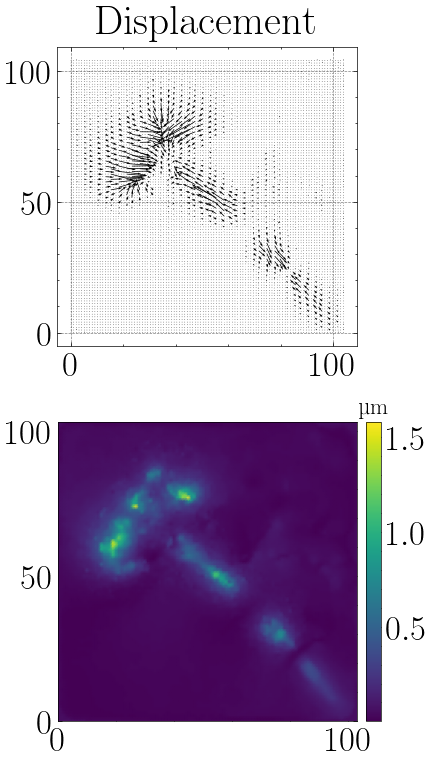

In [19]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

get_ipython().run_line_magic('matplotlib', 'notebook')
%matplotlib inline
plt.style.use(['science', 'grid', 'muted'])

i = 0

fig, axs = plt.subplots(2, 1, figsize=(6, 9))
fig.tight_layout(pad=2, w_pad=0, h_pad=3)

sparse_dspl = real_cells[i]['dspl'] * np.resize([[0, 0, 0, 0],[0, 1, 0, 0],[0, 0, 1, 0],[0, 0, 0, 1]], (104,104))
#sparse_dspl[0, 5, 5] = 1.925 * 1 *   # 5.787 * 16 * 0.108 [micrometer] = 10 [micrometer]
#sparse_dspl[1, 5, 5] = 0
x = np.linspace(0, 104, 104)
y = np.linspace(0, 104, 104)
axs[0].quiver(x, y, sparse_dspl[0, :, :], sparse_dspl[1, :, :], angles='xy', scale_units='xy', scale=1/10)
axs[0].set(adjustable='box', aspect='equal')
axs[0].set_title('Displacement', pad=10, fontsize=30)
#axs[0].annotate(u'10 \xb5m',
#                fontsize=12,
#                xy=(0.1, 0.1), 
#                xytext=(11, 5),
#                textcoords='offset points')

#axs[0].quiver(real_cells[i]['dspl'][0, :, :].detach().numpy(), real_cells[i]['dspl'][1, :, :].detach().numpy(), scale=1/5)
#axs[0].set(adjustable='box', aspect='equal')

#axs[0].plot(real_cells[i]['brdx'][0], real_cells[i]['brdy'][0], c='grey')
axs[0].set_title('Displacement', pad=10, fontsize=30)
#axs[0].text(80, 110, 'Displacement', fontsize=35)
#dx = 5 * 0.51948
#dy = 0
#axs[0].arrow(x=10, y=10, dx=dx, dy=dy, head_width=1.3, color='black')
#axs[0].annotate(u'5 \xb5m',
#                fontsize=13,
#                xy=(0.1, 0.1), 
#                xytext=(11, 8),
#                textcoords='offset points')

C = np.sqrt(real_cells[i]['dspl'][0, :, :].detach().numpy() ** 2 + real_cells[i]['dspl'][1, :, :].detach().numpy() ** 2)
im = axs[1].pcolormesh(C, shading='gouraud')
#axs[1].plot(real_cells[i]['brdx'][0], real_cells[i]['brdy'][0], c='white')
#axs[1].set_title(r'Displacement', pad=10, fontsize=35)
colorbar = fig.colorbar(im, ax=axs[1], pad=0.02)
colorbar.ax.set_title(u'\xb5m', fontsize=17)
axs[1].set(adjustable='box', aspect='equal')
#cb_ax = fig.add_axes([.91,.124,.04,.754])
#fig.colorbar(im,orientation='vertical',cax=cb_ax)

fig.subplots_adjust(top=0.82)

image_name = 'Real_dspl_vert.jpeg'
#fig.savefig(f'/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/{image_name}', format='jpeg', dpi=1000)

In [12]:
norm = matplotlib.colors.Normalize(vmin=0.0,vmax=np.max(np.sqrt(TFM_results_padded[0, :, :].detach().numpy() ** 2 + TFM_results_padded[1, :, :].detach().numpy() ** 2)))

In [13]:
real_cells[i]['vit_pred'].shape

torch.Size([1, 2, 104, 104])

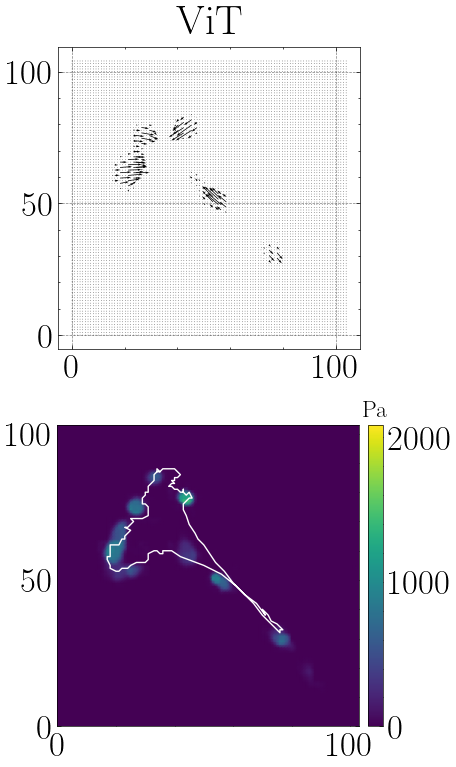

In [35]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

get_ipython().run_line_magic('matplotlib', 'notebook')
%matplotlib inline
plt.style.use(['science', 'grid', 'muted'])

fig, axs = plt.subplots(2, 1, figsize=(6, 9))
fig.tight_layout(pad=2, w_pad=0, h_pad=3)

#i = 0
#axs[0].quiver(real_cells[i]['vit_pred'][0, 0, :, :].detach().numpy(), real_cells[i]['vit_pred'][0, 1, :, :].detach().numpy(), scale=10670)
#axs[0].set(adjustable='box', aspect='equal')
#axs[0].set_title('ViT', pad=10, fontsize=30)
#axs[0].plot(real_%matplotlib inlinecells[i]['brdx'][0], real_cells[i]['brdy'][0], c='grey')

##sparse_pred = real_cells[i]['vit_pred'].detach() * np.resize([[1, 0],[1, 0]], (104,104))
#sparse_pred = real_cells[i]['vit_pred'].detach()
sparse_dspl[0, 5, 5] = 1.925 * 5.787   # 5.787 * 16 * 0.108 [micrometer] = 10 [micrometer]
sparse_dspl[1, 5, 5] = 0
x = np.linspace(0, 104, 104)
y = np.linspace(0, 104, 104)
axs[0].quiver(x, y, sparse_pred[0, 0, :, :], sparse_pred[0, 1, :, :], angles='xy', scale_units='xy', scale=104)
axs[0].set(adjustable='box', aspect='equal')
axs[0].set_title('ViT', pad=10, fontsize=30)
#axs[0].annotate(u'10 \xb5m',
#                fontsize=12,
#                xy=(0.1, 0.1),
#                xytext=(11, 5),
#                textcoords='offset points')

#dx = 9
#dy = 0
#axs[0].arrow(x=10, y=10, dx=dx, dy=dy, head_width=1, color='black')
#axs[0].annotate(u'1000 Pa',
#                fontsize=13,
#                xy=(0.2, 0.2), 
#                xytext=(11, 8),
#                textcoords='offset points')

C = np.sqrt(real_cells[i]['vit_pred'][0, 0, :, :].detach().numpy() ** 2 + real_cells[i]['vit_pred'][0, 1, :, :].detach().numpy() ** 2)
im = axs[1].pcolormesh(C, shading='gouraud', norm=norm)
axs[1].plot(real_cells[i]['brdx'][0], real_cells[i]['brdy'][0], c='white')
colorbar = fig.colorbar(im, ax=axs[1], pad=0.02, norm=norm)
colorbar.ax.set_title(u'Pa', fontsize=17)
axs[1].set(adjustable='box', aspect='equal')

fig.subplots_adjust(top=0.825)

#image_name = 'Real_vit_vert.jpeg'
#fig.savefig(f'/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/{image_name}', format='jpeg', dpi=1000)

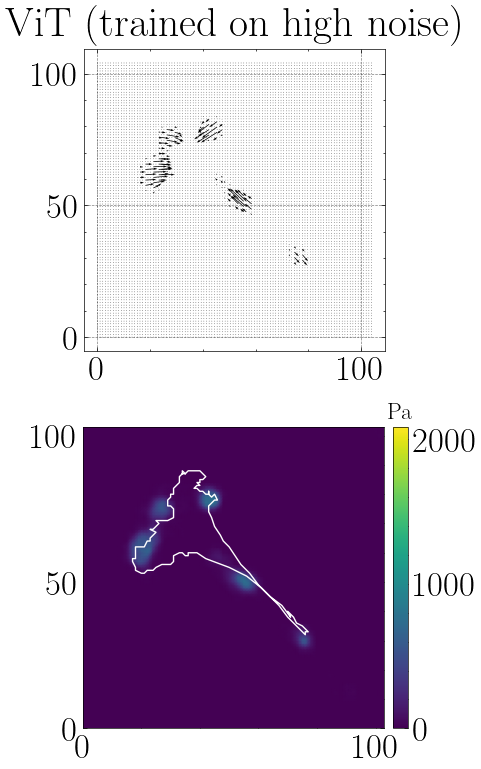

In [38]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

get_ipython().run_line_magic('matplotlib', 'notebook')
%matplotlib inline
plt.style.use(['science', 'grid', 'muted'])

fig, axs = plt.subplots(2, 1, figsize=(6, 9))
fig.tight_layout(pad=2, w_pad=0, h_pad=3)

#i = 0
#axs[0].quiver(real_cells[i]['vit_pred'][0, 0, :, :].detach().numpy(), real_cells[i]['vit_pred'][0, 1, :, :].detach().numpy(), scale=10670)
#axs[0].set(adjustable='box', aspect='equal')
#axs[0].set_title('ViT', pad=10, fontsize=30)
#axs[0].plot(real_%matplotlib inlinecells[i]['brdx'][0], real_cells[i]['brdy'][0], c='grey')

sparse_pred = real_cells[i]['vit_high_pred'].detach() * np.resize([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 1, 0],[0, 0, 0, 1]], (104,104))
#sparse_pred = real_cells[i]['vit_high_pred'].detach()
#sparse_dspl[0, 5, 5] = 1.925 * 1 *   # 5.787 * 16 * 0.108 [micrometer] = 10 [micrometer]
#sparse_dspl[1, 5, 5] = 0
x = np.linspace(0, 104, 104)
y = np.linspace(0, 104, 104)
axs[0].quiver(x, y, sparse_pred[0, 0, :, :], sparse_pred[0, 1, :, :], angles='xy', scale_units='xy', scale=104)
axs[0].set(adjustable='box', aspect='equal')
axs[0].set_title('ViT (trained on high noise)', pad=10, fontsize=30)
#axs[0].annotate(u'10 \xb5m',
#                fontsize=12,
#                xy=(0.1, 0.1),
#                xytext=(11, 5),
#                textcoords='offset points')

#dx = 9
#dy = 0
#axs[0].arrow(x=10, y=10, dx=dx, dy=dy, head_width=1, color='black')
#axs[0].annotate(u'1000 Pa',
#                fontsize=13,
#                xy=(0.2, 0.2), 
#                xytext=(11, 8),
#                textcoords='offset points')

C = np.sqrt(real_cells[i]['vit_high_pred'][0, 0, :, :].detach().numpy() ** 2 + real_cells[i]['vit_high_pred'][0, 1, :, :].detach().numpy() ** 2)
im = axs[1].pcolormesh(C, shading='gouraud', norm=norm)
axs[1].plot(real_cells[i]['brdx'][0], real_cells[i]['brdy'][0], c='white')
colorbar = fig.colorbar(im, ax=axs[1], pad=0.02, norm=norm)
colorbar.ax.set_title(u'Pa', fontsize=17)
axs[1].set(adjustable='box', aspect='equal')

fig.subplots_adjust(top=0.825)

#image_name = 'Real_vit_vert.jpeg'
#fig.savefig(f'/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/{image_name}', format='jpeg', dpi=1000)

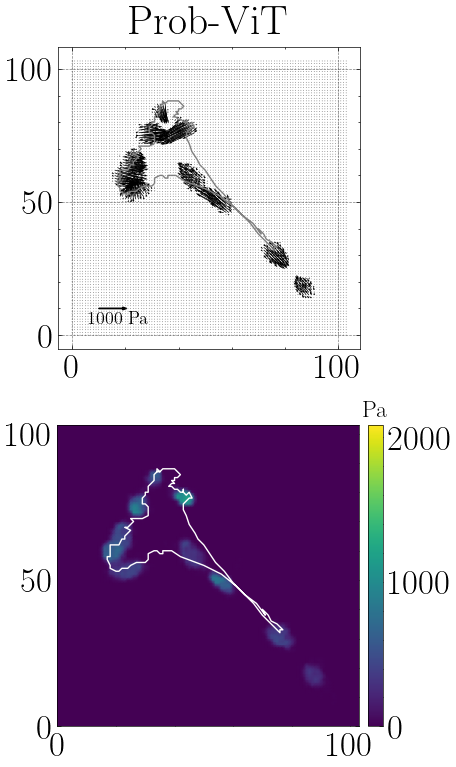

In [85]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

get_ipython().run_line_magic('matplotlib', 'notebook')
%matplotlib inline
plt.style.use(['science', 'grid', 'muted'])

fig, axs = plt.subplots(2, 1, figsize=(6, 9))
fig.tight_layout(pad=2, w_pad=0, h_pad=3)

i = 0
axs[0].quiver(real_cells[i]['prob_vit_pred'][0, 0, :, :].detach().numpy(), real_cells[i]['prob_vit_pred'][0, 1, :, :].detach().numpy()  , scale=10670)
axs[0].set(adjustable='box', aspect='equal')
axs[0].set_title('Prob-ViT', pad=10, fontsize=30)
axs[0].plot(real_cells[i]['brdx'][0], real_cells[i]['brdy'][0], c='grey')

dx = 9
dy = 0
axs[0].arrow(x=10, y=10, dx=dx, dy=dy, head_width=1, color='black')
axs[0].annotate(u'1000 Pa',
                fontsize=13,
                xy=(0.2, 0.2), 
                xytext=(11, 8),
                textcoords='offset points')

C = np.sqrt(real_cells[i]['prob_vit_pred'][0, 0, :, :].detach().numpy() ** 2 + real_cells[i]['prob_vit_pred'][0, 1, :, :].detach().numpy() ** 2)
im = axs[1].pcolormesh(C, shading='gouraud', norm=norm)
axs[1].plot(real_cells[i]['brdx'][0], real_cells[i]['brdy'][0], c='white')
colorbar = fig.colorbar(im, ax=axs[1], pad=0.02, norm=norm)
colorbar.ax.set_title(u'Pa', fontsize=17)
axs[1].set(adjustable='box', aspect='equal')

fig.subplots_adjust(top=0.825)

image_name = 'Real_prob-vit_vert.jpeg'
fig.savefig(f'/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/{image_name}', format='jpeg', dpi=1000)

<IPython.core.display.Javascript object>


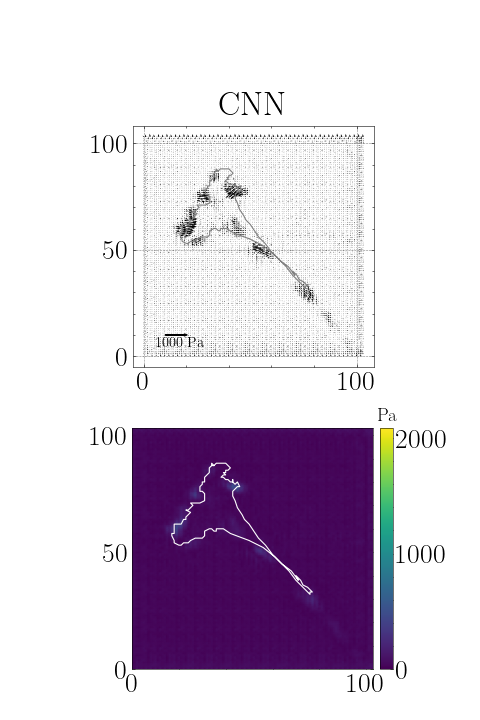

In [443]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

get_ipython().run_line_magic('matplotlib', 'notebook')
plt.style.use(['science', 'grid', 'muted'])

fig, axs = plt.subplots(2, 1, figsize=(6, 9))
fig.tight_layout(pad=2, w_pad=0, h_pad=3)

i = 0
axs[0].quiver(real_cells[i]['cnn_pred'][0, :, :, 0], real_cells[i]['cnn_pred'][0, :, :, 1], scale=10670)
axs[0].set(adjustable='box', aspect='equal')
axs[0].set_title('CNN', pad=10, fontsize=30)
axs[0].plot(real_cells[i]['brdx'][0], real_cells[i]['brdy'][0], c='grey')

dx = 9
dy = 0
axs[0].arrow(x=10, y=10, dx=dx, dy=dy, head_width=1, color='black')
axs[0].annotate(u'1000 Pa',
                fontsize=13,
                xy=(0.2, 0.2), 
                xytext=(11, 8),
                textcoords='offset points')

C = np.sqrt(real_cells[i]['cnn_pred'][0, :, :, 0] ** 2 + real_cells[i]['cnn_pred'][0, :, :, 1] ** 2)
im = axs[1].pcolormesh(C, shading='gouraud', norm=norm)
axs[1].plot(real_cells[i]['brdx'][0], real_cells[i]['brdy'][0], c='white')
colorbar = fig.colorbar(im, ax=axs[1], pad=0.02, norm=norm)
colorbar.ax.set_title(u'Pa', fontsize=17)
axs[1].set(adjustable='box', aspect='equal')

fig.subplots_adjust(top=0.825)

image_name = 'Real_cnn_vert.jpeg'
fig.savefig(f'/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/{image_name}', format='jpeg', dpi=1000)

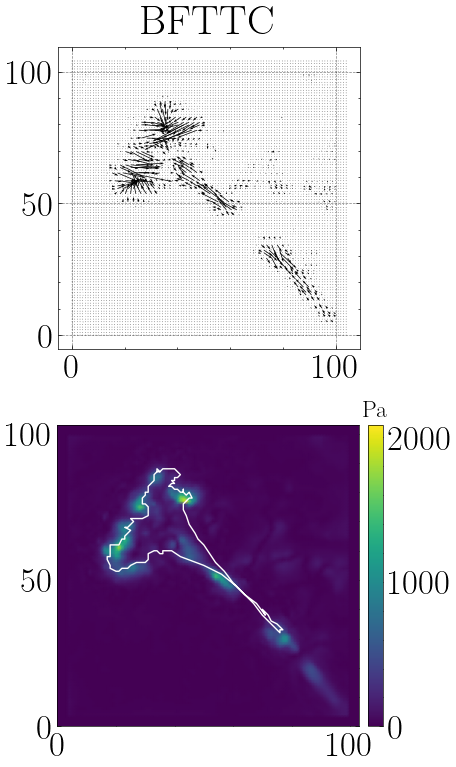

In [44]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

get_ipython().run_line_magic('matplotlib', 'notebook')
%matplotlib inline
plt.style.use(['science', 'grid', 'muted'])

fig, axs = plt.subplots(2, 1, figsize=(6, 9))
fig.tight_layout(pad=2, w_pad=0, h_pad=3)


sparse_pred = TFM_results_padded.detach() * np.resize([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 1, 0],[0, 0, 0, 1]], (104,104))
#sparse_pred = real_cells[i]['vit_high_pred'].detach()
#sparse_dspl[0, 5, 5] = 1.925 * 1 *   # 5.787 * 16 * 0.108 [micrometer] = 10 [micrometer]
#sparse_dspl[1, 5, 5] = 0
x = np.linspace(0, 104, 104)
y = np.linspace(0, 104, 104)
axs[0].quiver(x, y, sparse_pred[0, :, :].T, sparse_pred[1, :, :].T, angles='xy', scale_units='xy', scale=104)
axs[0].set(adjustable='box', aspect='equal')
axs[0].set_title('BFTTC', pad=10, fontsize=30)
#axs[0].annotate(u'10 \xb5m',
#                fontsize=12,
#                xy=(0.1, 0.1),
#                xytext=(11, 5),
#                textcoords='offset points')

#dx = 9
#dy = 0
#axs[0].arrow(x=10, y=10, dx=dx, dy=dy, head_width=1, color='black')
#axs[0].annotate(u'1000 Pa',
#                fontsize=13,
#                xy=(0.2, 0.2), 
#                xytext=(11, 8),
#                textcoords='offset points')

'''
i = 0
axs[0].quiver(TFM_results_padded[0, :, :].detach().numpy().T, TFM_results_padded[1, :, :].detach().numpy().T, scale=10670)
axs[0].set(adjustable='box', aspect='equal')
axs[0].set_title('BFTTC', pad=10, fontsize=30)
axs[0].plot(real_cells[i]['brdx'][0], real_cells[i]['brdy'][0], c='grey')

dx = 9
dy = 0
axs[0].arrow(x=10, y=10, dx=dx, dy=dy, head_width=1, color='black')
axs[0].annotate(u'1000 Pa',
                fontsize=13,
                xy=(0.2, 0.2), 
                xytext=(11, 8),
                textcoords='offset points')
'''

C = np.sqrt(TFM_results_padded[0, :, :].detach().numpy().T ** 2 + TFM_results_padded[1, :, :].detach().numpy().T ** 2)
im = axs[1].pcolormesh(C, shading='gouraud', norm=norm)
axs[1].plot(real_cells[i]['brdx'][0], real_cells[i]['brdy'][0], c='white')
colorbar = fig.colorbar(im, ax=axs[1], pad=0.02, norm=norm)
colorbar.ax.set_title(u'Pa', fontsize=17)
axs[1].set(adjustable='box', aspect='equal')

fig.subplots_adjust(top=0.825)

image_name = 'Real_bfttc_vert.jpeg'
fig.savefig(f'/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/{image_name}', format='jpeg', dpi=1000)

scale conversion:
1 model pixel = 7 camera pixel, 
104mp = 7 * 104 * 0.275 micrometer = 200.2 micrometer = 0.2002 mm

### Fibroblast

In [9]:
Bay_FTTC_output = loadmat('/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/Real cell/Cell4/Bay-FTTC_results_24-07-23.mat')
Bay_FTTC_output['TFM_settings']

array([[(array([[0.5]]), array([[10000]], dtype=uint16), array([[0.108]]), array([[230.82756012]]), array([[16]], dtype=uint8), array([[0]], dtype=uint8), array([[54]], dtype=uint8), array([[54]], dtype=uint8), array(['Region of interest for noise selected manually'], dtype='<U46'))]],
      dtype=[('poisson', 'O'), ('young', 'O'), ('micrometer_per_pix', 'O'), ('regularization_parameter', 'O'), ('meshsize', 'O'), ('zdepth', 'O'), ('i_max', 'O'), ('j_max', 'O'), ('type_noise', 'O')])

Poisson's ratio: 0.5 <br>
Young's modulus: 10000 Pa <br>
Micrometer per pixel : 0.108 <br>
Number of pixel per dimension: 54 * 16 <br>

In [10]:
dspl = Bay_FTTC_output['TFM_results']['displacement'][0][0].T.reshape((2, 54, 54), order='F')
dspl_padded = F.pad(input=torch.tensor(dspl).float(), pad=(1, 1, 1, 1), mode='constant', value=0)
dspl_padded_big = F.pad(input=torch.tensor(dspl).float(), pad=(25, 25, 25, 25), mode='constant', value=0)

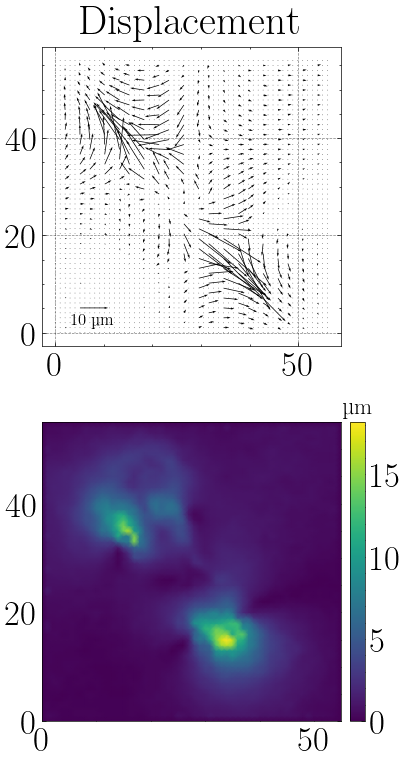

In [11]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

get_ipython().run_line_magic('matplotlib', 'notebook')
%matplotlib inline

plt.style.use(['science', 'grid', 'muted'])

fig, axs = plt.subplots(2, 1, figsize=(6, 9))
fig.tight_layout(pad=2, w_pad=0, h_pad=3)

sparse_dspl = dspl_padded * np.resize([[0, 0, 0, 0],[0, 1, 0, 0],[0, 0, 1, 0],[0, 0, 0, 1]], (56,56))
sparse_dspl[0, 5, 5] = 5.787  # 5.787 * 16 * 0.108 [micrometer] = 10 [micrometer]
sparse_dspl[1, 5, 5] = 0
x = np.linspace(0, 56, 56)
y = np.linspace(0, 56, 56)
axs[0].quiver(x, y, sparse_dspl[0, :, :], sparse_dspl[1, :, :], angles='xy', scale_units='xy', scale=1)
axs[0].set(adjustable='box', aspect='equal')
axs[0].set_title('Displacement', pad=10, fontsize=30)
axs[0].annotate(u'10 \xb5m',
                fontsize=12,
                xy=(0.1, 0.1), 
                xytext=(11, 5),
                textcoords='offset points')

norm = matplotlib.colors.Normalize(vmin=0.0, vmax=np.max(np.sqrt(np.array(dspl_padded[0, :, :] ** 2 + dspl_padded[1, :, :] ** 2))))
C = np.sqrt(dspl_padded[0, :, :] ** 2 + dspl_padded[1, :, :] ** 2)
im = axs[1].pcolormesh(C, shading='gouraud', norm=norm)
colorbar = fig.colorbar(im, ax=axs[1], pad=0.02)
colorbar.ax.set_title(u'\xb5m', fontsize=17)
axs[1].set(adjustable='box', aspect='equal')

fig.subplots_adjust(top=0.82)

image_name = 'Real_dspl_vert.jpeg'
#fig.savefig(f'/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/{image_name}', format='jpeg', dpi=1000)

In [41]:
bfttc_result = np.pad(
    array=Bay_FTTC_output['TFM_results']['traction'][0][0].T.reshape((2, 54, 54), order='F'),
    pad_width=((0,0),(1,1),(1,1)),
    mode='constant',
    constant_values=0)
bfttc_result_large = F.pad(input=torch.tensor(bfttc_result).float(), pad=(25, 25, 25, 25), mode='constant', value=0)
vit_pred = vit((1 / (56 * 16 * 0.108)) * dspl_padded.unsqueeze(0), src_size=(1, 13, 13, -1), tgt_size=(7, 7), interpolate=True) * 10000
vit_pred_high = vit_high((1 / (56 * 16 * 0.108)) * dspl_padded.unsqueeze(0), src_size=(1, 13, 13, -1), tgt_size=(7, 7), interpolate=True) * 10000

vit_pred_large = vit((1 / (104 * 16 * 0.108)) * dspl_padded_big.unsqueeze(0), src_size=(1, 13, 13, -1), tgt_size=(7, 7), interpolate=False) * 10000
vit_pred_high_large = vit_high((1 / (104 * 16 * 0.108)) * dspl_padded_big.unsqueeze(0), src_size=(1, 13, 13, -1), tgt_size=(7, 7), interpolate=False) * 10000
prob_vit_pred_large = prob_vit((1 / (104 * 16 * 0.108)) * dspl_padded_big.unsqueeze(0)) * 10000
cnn_pred_large = cnn.predict(np.expand_dims(np.moveaxis(np.array(dspl_padded_big), 0, 2), 0)) * 10000

# vit_pred = vit((1 / (104 * 16 * 0.108)) * dspl_padded_big.unsqueeze(0), src_size=(1, 13, 13, -1), tgt_size=(13, 13), interpolate=False) * 10000
#cnn_pred = cnn.predict(np.expand_dims(np.moveaxis(np.array((1 / (104 * 16 * 0.108)) * dspl_padded_big), 0, 2), 0)) * 10000

torch.Size([1, 169, 128])
torch.Size([1, 13, 13, 128])
torch.Size([1, 128, 13, 13])
torch.Size([1, 128, 7, 7])
torch.Size([1, 49, 128])
torch.Size([1, 169, 128])
torch.Size([1, 13, 13, 128])
torch.Size([1, 128, 13, 13])
torch.Size([1, 128, 7, 7])
torch.Size([1, 49, 128])
1/1 [==============================] - 0s 14ms/step


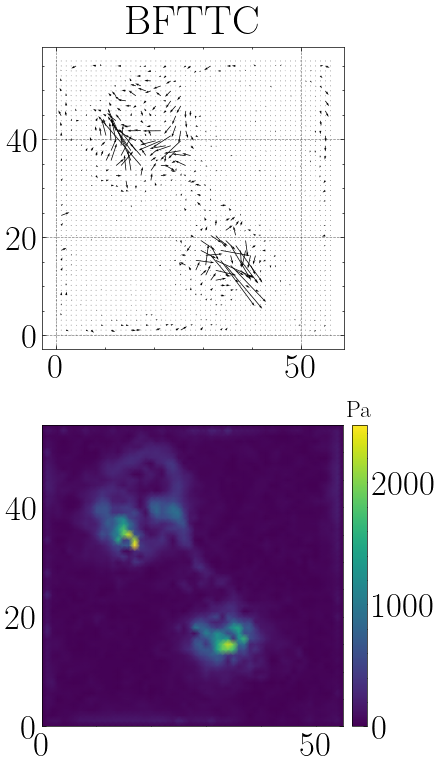

In [62]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

get_ipython().run_line_magic('matplotlib', 'notebook')
%matplotlib inline
plt.style.use(['science', 'grid', 'muted'])

fig, axs = plt.subplots(2, 1, figsize=(6, 9))
fig.tight_layout(pad=2, w_pad=0, h_pad=3)

sparse_pred = bfttc_result * np.resize([[1, 0, 0],[0, 1, 0], [0, 0, 1]], (56, 56))
#sparse_dspl[0, 5, 5] = 5.787  # 5.787 * 16 * 0.108 [micrometer] = 10 [micrometer]
#sparse_dspl[1, 5, 5] = 0

x = np.linspace(0, 56, 56)
y = np.linspace(0, 56, 56)
axs[0].quiver(x, y, sparse_pred[0, :, :], sparse_pred[1, :, :], angles='xy', scale=10000)
axs[0].set(adjustable='box', aspect='equal')
axs[0].set_title('BFTTC', pad=10, fontsize=30)
#axs[0].annotate(u'10 \xb5m',
#                fontsize=12,
#                xy=(0.1, 0.1), 
#                xytext=(11, 5),
#                textcoords='offset points')

norm = matplotlib.colors.Normalize(vmin=0.0, vmax=np.max(np.sqrt(np.array(bfttc_result[0, :, :] ** 2 + bfttc_result[1, :, :] ** 2))))
C = np.sqrt(bfttc_result[0, :, :] ** 2 + bfttc_result[1, :, :] ** 2)
im = axs[1].pcolormesh(C, shading='gouraud', norm=norm)
colorbar = fig.colorbar(im, ax=axs[1], pad=0.02, norm=norm)
colorbar.ax.set_title(u'Pa', fontsize=17)
axs[1].set(adjustable='box', aspect='equal')
dspl_padded_big
fig.subplots_adjust(top=0.825)

image_name = 'Real_bfttc_vert.jpeg'
#fig.savefig(f'/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/{image_name}', format='jpeg', dpi=1000)

In [52]:
torch.max(torch.sqrt((vit_pred[0, 0, :, :] ** 2 + vit_pred[0, 1, :, :] ** 2)))

tensor(7017.357422, grad_fn=<MaxBackward1>)

In [53]:
torch.max(torch.sqrt((vit_pred_high[0, 0, :, :] ** 2 + vit_pred_high[0, 1, :, :] ** 2)))

tensor(6615.048828, grad_fn=<MaxBackward1>)

In [54]:
np.max(np.sqrt(bfttc_result[0, :, :] ** 2 + bfttc_result[1, :, :] ** 2))

2470.570093563491

In [23]:
#np.max(np.sqrt(cnn_pred[0, :, :, 0] ** 2 + cnn_pred[0, :, :, 1] ** 2))

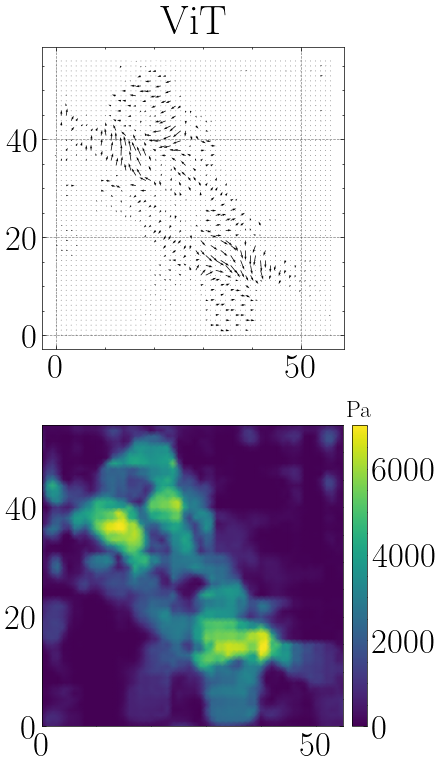

In [64]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

get_ipython().run_line_magic('matplotlib', 'notebook')
%matplotlib inline
plt.style.use(['science', 'grid', 'muted'])

fig, axs = plt.subplots(2, 1, figsize=(6, 9))
fig.tight_layout(pad=2, w_pad=0, h_pad=3)

sparse_pred = vit_pred * torch.tensor(np.resize([[1, 0, 0],[0, 1, 0], [0, 0, 1]], (56, 56)))
#sparse_dspl[0, 5, 5] = 5.787  # 5.787 * 16 * 0.108 [micrometer] = 10 [micrometer]
#sparse_dspl[1, 5, 5] = 0
x = np.linspace(0, 56, 56)
y = np.linspace(0, 56, 56)
axs[0].quiver(x, y, sparse_pred[0, 0, :, :].detach(), sparse_pred[0, 1, :, :].detach(), scale=3000, units='xy', angles='xy')
axs[0].set(adjustable='box', aspect='equal')
axs[0].set_title('ViT', pad=10, fontsize=30)

#dx = 9
#dy = 0
#axs[0].arrow(x=10, y=10, dx=dx, dy=dy, head_width=1, color='black')
#axs[0].annotate(u'1000 Pa',
#                fontsize=13,
#                xy=(0.2, 0.2), 
#                xytext=(11, 8),
#                textcoords='offset points')

norm = matplotlib.colors.Normalize(vmin=0.0, vmax=np.max(np.sqrt(np.array(sparse_pred[0, 0, :, :].detach()) ** 2 + np.array(sparse_pred[0, 1, :, :].detach()) ** 2)))
C = np.sqrt(vit_pred[0, 0, :, :].detach().numpy() ** 2 + vit_pred[0, 1, :, :].detach().numpy() ** 2)
im = axs[1].pcolormesh(C, shading='gouraud', norm=norm)
colorbar = fig.colorbar(im, ax=axs[1], pad=0.02, norm=norm)
colorbar.ax.set_title(u'Pa', fontsize=17)
axs[1].set(adjustable='box', aspect='equal')

fig.subplots_adjust(top=0.825)

#image_name = 'Real_vit_vert.jpeg'
#fig.savefig(f'/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/{image_name}', format='jpeg', dpi=1000)

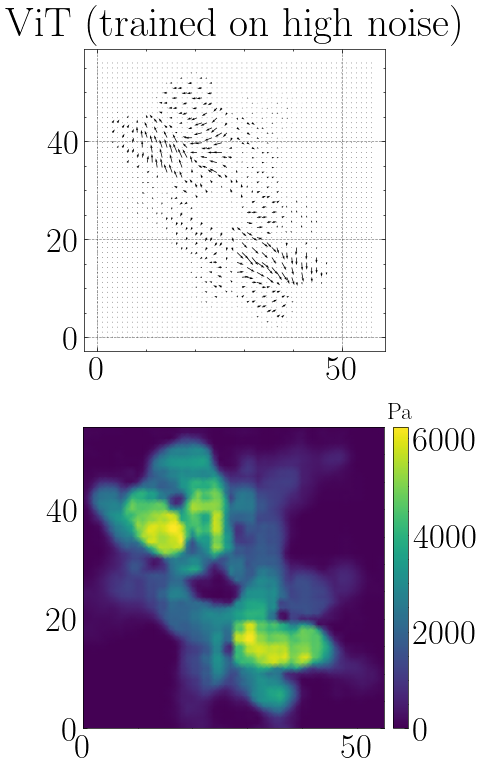

In [65]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

get_ipython().run_line_magic('matplotlib', 'notebook')
%matplotlib inline
plt.style.use(['science', 'grid', 'muted'])

fig, axs = plt.subplots(2, 1, figsize=(6, 9))
fig.tight_layout(pad=2, w_pad=0, h_pad=3)

sparse_pred = vit_pred_high * torch.tensor(np.resize([[1, 0, 0],[0, 1, 0], [0, 0, 1]], (56, 56)))
#sparse_dspl[0, 5, 5] = 5.787  # 5.787 * 16 * 0.108 [micrometer] = 10 [micrometer]
#sparse_dspl[1, 5, 5] = 0
x = np.linspace(0, 56, 56)
y = np.linspace(0, 56, 56)
axs[0].quiver(x, y, sparse_pred[0, 0, :, :].detach(), sparse_pred[0, 1, :, :].detach(), scale=3000, units='xy', angles='xy')
axs[0].set(adjustable='box', aspect='equal')
axs[0].set_title('ViT (trained on high noise)', pad=10, fontsize=30)

#dx = 9
#dy = 0
#axs[0].arrow(x=10, y=10, dx=dx, dy=dy, head_width=1, color='black')
#axs[0].annotate(u'1000 Pa',
#                fontsize=13,
#                xy=(0.2, 0.2), 
#                xytext=(11, 8),
#                textcoords='offset points')

norm = matplotlib.colors.Normalize(vmin=0.0, vmax=np.max(np.sqrt(np.array(sparse_pred[0, 0, :, :].detach()) ** 2 + np.array(sparse_pred[0, 1, :, :].detach()) ** 2)))
C = np.sqrt(vit_pred_high[0, 0, :, :].detach().numpy() ** 2 + vit_pred_high[0, 1, :, :].detach().numpy() ** 2)
im = axs[1].pcolormesh(C, shading='gouraud', norm=norm)
colorbar = fig.colorbar(im, ax=axs[1], pad=0.02, norm=norm)
colorbar.ax.set_title(u'Pa', fontsize=17)
axs[1].set(adjustable='box', aspect='equal')

fig.subplots_adjust(top=0.825)

#image_name = 'Real_vit_vert.jpeg'
#fig.savefig(f'/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/{image_name}', format='jpeg', dpi=1000)

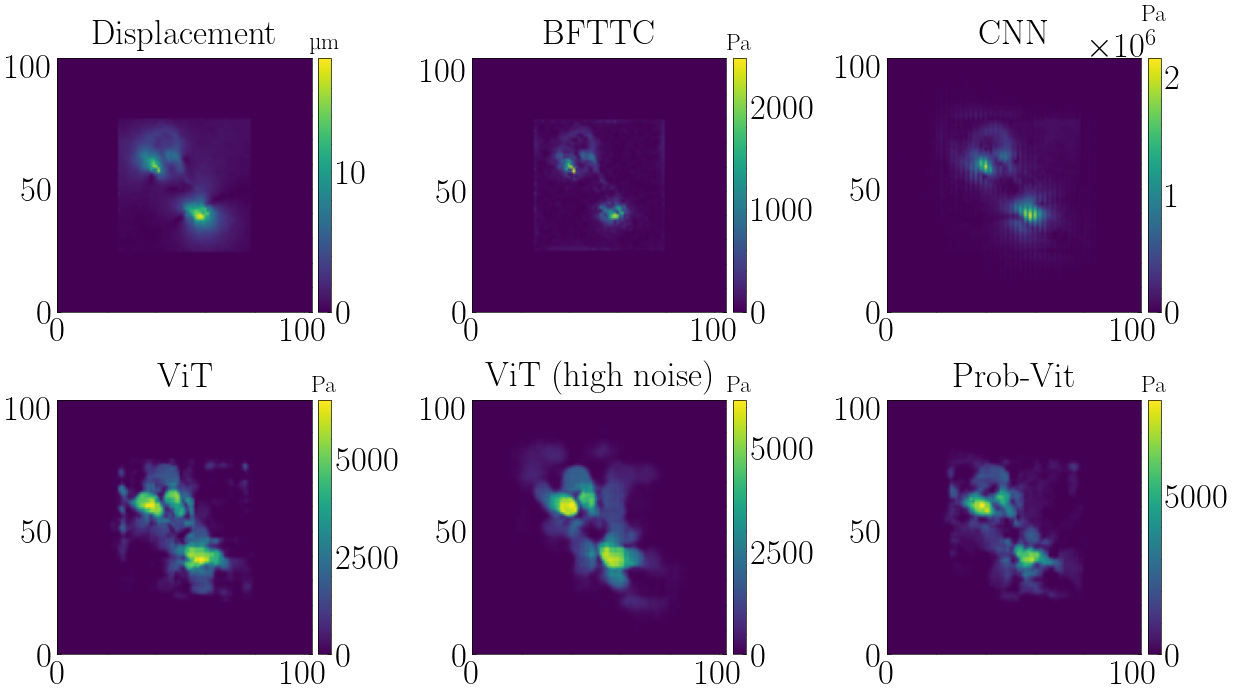

In [43]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25

get_ipython().run_line_magic('matplotlib', 'notebook')
%matplotlib inline
plt.style.use(['science', 'grid', 'muted'])

fig, axs = plt.subplots(2, 3, figsize=(13, 8))
fig.tight_layout(pad=2, w_pad=0, h_pad=4)

norm = matplotlib.colors.Normalize(vmin=0.0, vmax=np.max(np.sqrt(np.array(dspl_padded_big[0, :, :] ** 2 + dspl_padded_big[1, :, :] ** 2))))
C = np.sqrt(dspl_padded_big[0, :, :] ** 2 + dspl_padded_big[1, :, :] ** 2)
im = axs[0,0].pcolormesh(C, shading='gouraud', norm=norm)
colorbar = fig.colorbar(im, ax=axs[0,0], pad=0.02)
colorbar.ax.set_title(u'\xb5m', fontsize=17)
axs[0,0].set(adjustable='box', aspect='equal')
axs[0,0].set_title('Displacement', pad=10, fontsize=25)

norm = matplotlib.colors.Normalize(vmin=0.0, vmax=np.max(np.sqrt(np.array(bfttc_result[0, :, :] ** 2 + bfttc_result[1, :, :] ** 2))))
C = np.sqrt(bfttc_result_large[0, :, :] ** 2 + bfttc_result_large[1, :, :] ** 2)
im = axs[0,1].pcolormesh(C, shading='gouraud', norm=norm)
colorbar = fig.colorbar(im, ax=axs[0,1], pad=0.02, norm=norm)
colorbar.ax.set_title(u'Pa', fontsize=17)
axs[0,1].set(adjustable='box', aspect='equal')
axs[0,1].set_title('BFTTC', pad=10, fontsize=25)

norm = matplotlib.colors.Normalize(vmin=0.0, vmax=np.max(np.sqrt(cnn_pred_large[0, :, :, 0] ** 2 + cnn_pred_large[0, :, :, 1] ** 2)))
C = np.sqrt(cnn_pred_large[0, :, :, 0] ** 2 + cnn_pred_large[0, :, :, 1] ** 2)
im = axs[0,2].pcolormesh(C, shading='gouraud', norm=norm)
colorbar = fig.colorbar(im, ax=axs[0,2], pad=0.02, norm=norm)
colorbar.ax.set_title(u'Pa', fontsize=17)
axs[0,2].set(adjustable='box', aspect='equal')
axs[0,2].set_title('CNN', pad=10, fontsize=25)

norm = matplotlib.colors.Normalize(vmin=0.0, vmax=np.max(np.sqrt(vit_pred_large[0, 0, :, :].detach().numpy() ** 2 + vit_pred_large[0, 1, :, :].detach().numpy() ** 2)))
C = np.sqrt(vit_pred_large[0, 0, :, :].detach().numpy() ** 2 + vit_pred_large[0, 1, :, :].detach().numpy() ** 2)
im = axs[1,0].pcolormesh(C, shading='gouraud', norm=norm)
colorbar = fig.colorbar(im, ax=axs[1,0], pad=0.02, norm=norm)
colorbar.ax.set_title(u'Pa', fontsize=17)
axs[1,0].set(adjustable='box', aspect='equal')
axs[1,0].set_title('ViT', pad=10, fontsize=25)

norm = matplotlib.colors.Normalize(vmin=0.0, vmax=np.max(np.sqrt(vit_pred_high_large[0, 0, :, :].detach().numpy() ** 2 + vit_pred_high_large[0, 1, :, :].detach().numpy() ** 2)))
C = np.sqrt(vit_pred_high_large[0, 0, :, :].detach().numpy() ** 2 + vit_pred_high_large[0, 1, :, :].detach().numpy() ** 2)
im = axs[1,1].pcolormesh(C, shading='gouraud', norm=norm)
colorbar = fig.colorbar(im, ax=axs[1,1], pad=0.02, norm=norm)
colorbar.ax.set_title(u'Pa', fontsize=17)
axs[1,1].set(adjustable='box', aspect='equal')
axs[1,1].set_title('ViT (high noise)', pad=10, fontsize=25)

norm = matplotlib.colors.Normalize(vmin=0.0, vmax=np.max(np.sqrt(prob_vit_pred_large[0, 0, :, :].detach().numpy() ** 2 + prob_vit_pred_large[0, 1, :, :].detach().numpy() ** 2)))
C = np.sqrt(prob_vit_pred_large[0, 0, :, :].detach().numpy() ** 2 + prob_vit_pred_large[0, 1, :, :].detach().numpy() ** 2)
im = axs[1,2].pcolormesh(C, shading='gouraud', norm=norm)
colorbar = fig.colorbar(im, ax=axs[1,2], pad=0.02, norm=norm)
colorbar.ax.set_title(u'Pa', fontsize=17)
axs[1,2].set(adjustable='box', aspect='equal')
axs[1,2].set_title('Prob-Vit', pad=10, fontsize=25)

fig.subplots_adjust(top=0.825)

image_name = 'Heatmap_panel.jpeg'
fig.savefig(f'/home/alexrichard/LRZ Sync+Share/ML in Physics/Thesis/Plots/{image_name}', format='jpeg', dpi=300)